# Modelos

En este notebook se probarán distintos modelos para predecir las propinas. El enfoque que se le va a dar al proyecto va a ser el siguiente:
- Modelo de clasificación. En primer lugar, se diseñará un modelo para clasificar los viajes en viajes de propinas bajas y viajes de propinas altas.
- Modelos de regresión. Tras la clasificación inicial, se diseñarán dos modelos de regresión, uno para cada clase.  

Dado que el objetivo principal es identificar el máximo posible de propinas altas ( >10$, clase 1) la métrica que se va a utilizar para evaluar los modelos es el f2-score, que aplica un coeficiente beta al f-score para asignar mas peso al recall en comparación con la precisión


In [32]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Machine learning supervisado
# ==============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, make_scorer, recall_score, precision_score
import xgboost

# Transformación logarítmica
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Guardar modelos
# ==============================================================================
import pickle


### Carga de datos

In [33]:
df = pd.read_csv('../../data/df_yellowtaxi_cleaned.csv', index_col='Unnamed: 0')
df_zones = pd.read_csv('../../data/taxi_zone_geo.csv')

In [34]:
df.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,congestion_surcharge,Airport_fee,pickup_DoW,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h),tolls_percentage,tip_amount
1,2.0,3.76506,1.0,236,233,1,14.2,True,2.5,0.00,4,Friday,00:18:40,0,708.0,11.898305,0.0,2.00
2,1.0,2.60658,1.0,162,236,1,8.6,True,2.5,0.00,4,Friday,00:35:01,0,243.0,24.000000,0.0,2.00
4,1.0,15.84865,1.0,138,230,1,45.0,True,2.5,1.75,4,Friday,00:01:23,0,2202.0,16.103542,0.0,17.02
7,1.0,6.27510,1.0,140,7,1,20.5,True,2.5,0.00,4,Friday,00:01:04,0,1052.0,13.346008,0.0,6.35
8,2.0,4.34430,1.0,45,164,1,16.3,True,2.5,0.00,4,Friday,00:37:44,0,880.0,11.045455,0.0,4.26


Se crea la variable target para el clasificador, que se va a llamar tip_category. Valdrá 0 para propinas menores a 10$, y 1 para propinas superiores a 10$.  
Para las zonas con poca representatividad se aplicará un suavizado, combinando la media global con la media de la zona

In [35]:
df['tip_category'] = [0 if x<10 else 1 for x in df['tip_amount']]

Para este modelo, se va a realizar un target encoding de las variable PULocationID y DOLocationID, asignando a cada zona la proporción de tips > 10$

In [36]:
# Factor de suavizado
m = 20  

# Porcentaje global de propinas >10$
global_high_tip_pct = (df['tip_amount'] > 10).mean()

# Calcular el porcentaje de propinas >10$ por zona y el número de registros por zona
zone_stats = df.groupby('PULocationID')['tip_amount'].agg(
    high_tip_pct=lambda x: (x > 10).mean(),  # Porcentaje de propinas >10$
    count='count'  # Número de registros
).reset_index()

# Aplicar el suavizado
zone_stats['smoothed_high_tip_pct'] = (
    (zone_stats['count'] * zone_stats['high_tip_pct'] + m * global_high_tip_pct) /
    (zone_stats['count'] + m)
)

# Mapear el porcentaje suavizado a la columna original
df['PULocationEncoded'] = df['PULocationID'].map(zone_stats.set_index('PULocationID')['smoothed_high_tip_pct'])
df.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,congestion_surcharge,Airport_fee,pickup_DoW,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h),tolls_percentage,tip_amount,tip_category,PULocationEncoded
1,2.0,3.76506,1.0,236,233,1,14.2,True,2.5,0.00,4,Friday,00:18:40,0,708.0,11.898305,0.0,2.00,0,0.020716
2,1.0,2.60658,1.0,162,236,1,8.6,True,2.5,0.00,4,Friday,00:35:01,0,243.0,24.000000,0.0,2.00,0,0.043326
4,1.0,15.84865,1.0,138,230,1,45.0,True,2.5,1.75,4,Friday,00:01:23,0,2202.0,16.103542,0.0,17.02,1,0.594823
7,1.0,6.27510,1.0,140,7,1,20.5,True,2.5,0.00,4,Friday,00:01:04,0,1052.0,13.346008,0.0,6.35,0,0.024413
8,2.0,4.34430,1.0,45,164,1,16.3,True,2.5,0.00,4,Friday,00:37:44,0,880.0,11.045455,0.0,4.26,0,0.055852


In [37]:
# Se aplica el mismo procedimiento para las ubicaciones de dropoff:
# Factor de suavizado
m = 20  

# Porcentaje global de propinas >10$
global_high_tip_pct = (df['tip_amount'] > 10).mean()

# Calcular el porcentaje de propinas >10$ por zona y el número de registros por zona
zone_stats = df.groupby('DOLocationID')['tip_amount'].agg(
    high_tip_pct=lambda x: (x > 10).mean(),  # Porcentaje de propinas >10$
    count='count'  # Número de registros
).reset_index()

# Aplicar el suavizado
zone_stats['smoothed_high_tip_pct'] = (
    (zone_stats['count'] * zone_stats['high_tip_pct'] + m * global_high_tip_pct) /
    (zone_stats['count'] + m)
)

# Mapear el porcentaje suavizado a la columna original
df['DOLocationEncoded'] = df['DOLocationID'].map(zone_stats.set_index('DOLocationID')['smoothed_high_tip_pct'])
df.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,congestion_surcharge,Airport_fee,...,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h),tolls_percentage,tip_amount,tip_category,PULocationEncoded,DOLocationEncoded
1,2.0,3.76506,1.0,236,233,1,14.2,True,2.5,0.00,...,Friday,00:18:40,0,708.0,11.898305,0.0,2.00,0,0.020716,0.073795
2,1.0,2.60658,1.0,162,236,1,8.6,True,2.5,0.00,...,Friday,00:35:01,0,243.0,24.000000,0.0,2.00,0,0.043326,0.031322
4,1.0,15.84865,1.0,138,230,1,45.0,True,2.5,1.75,...,Friday,00:01:23,0,2202.0,16.103542,0.0,17.02,1,0.594823,0.157589
7,1.0,6.27510,1.0,140,7,1,20.5,True,2.5,0.00,...,Friday,00:01:04,0,1052.0,13.346008,0.0,6.35,0,0.024413,0.139413
8,2.0,4.34430,1.0,45,164,1,16.3,True,2.5,0.00,...,Friday,00:37:44,0,880.0,11.045455,0.0,4.26,0,0.055852,0.116711


In [38]:
# Eliminamos del df las columnas DOLocationID y PULocationID
df = df.drop(columns = ['DOLocationID', 'PULocationID'])

Como se vio en el EDA, algunas features presentaban distribuciones de cola larga a la derecha, por lo que una transformación logarítmica de estas variables puede aplanar su distribución, beneficiando al rendimiento del modelo.

In [39]:
# Transformación logarítmica para variables seleccionadas
log_columns = ['trip_duration', 'avg_speed(km/h)']
log_transformer = FunctionTransformer(np.log1p)  # log(1 + x) para manejar ceros

preprocessor = ColumnTransformer(
    transformers=[
        ('log', log_transformer, log_columns)
    ],
    remainder='passthrough'  # El resto de columnas quedan sin modificar
)

En el anterior modelo vimos que una categorización de las variables fare_amount y trip_distance podría ser beneficiosa, por lo que se va a realizar a continuación

Text(0.5, 1.0, 'Trip distance distribution')

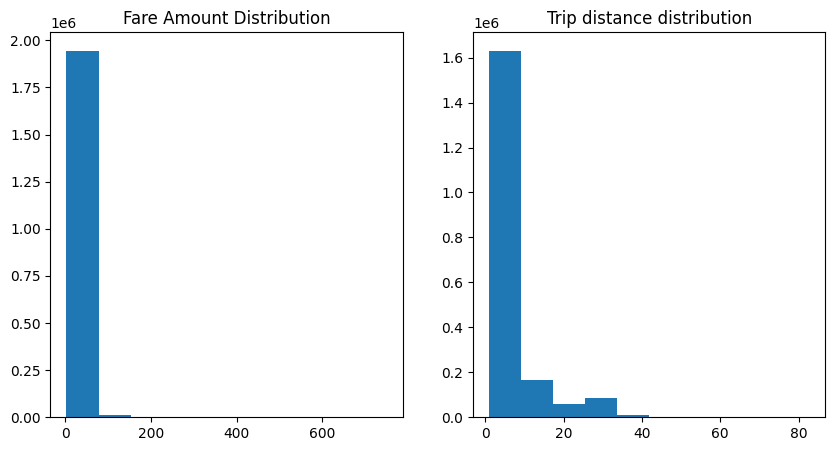

In [40]:
plt.figure (figsize =(10, 5))
plt.subplot(1,2,1)
plt.hist(df['fare_amount'])
plt.title('Fare Amount Distribution')

plt.subplot(1,2,2)
plt.hist(df['trip_distance'])
plt.title('Trip distance distribution')

In [41]:
df[['fare_amount', 'trip_distance']].describe().round(2)

,fare_amount,trip_distance
count,1959279.00,1959279.00
mean,21.21,5.98
std,16.93,7.18
min,3.00,1.01
25%,10.70,1.96
50%,14.90,3.15
75%,24.00,5.95
max,750.00,82.77


Para definir los límites de las categorías, se utilizarán los valores correspondientes al percentil 25 (primer cuartil) y al percentil 75 (tercer cuartil).

In [42]:
df['low_fare'] = [1 if x <= 10.7 else 0 for x in df['fare_amount']]
df['medium_fare'] = [1 if x > 10.7 and x < 24 else 0 for x in df['fare_amount']]
df['high_fare'] = [1 if x >= 24 else 0 for x in df['fare_amount']]

df['low_distance'] = [1 if x <= 1.96 else 0 for x in df['trip_distance']]
df['medium_distance'] = [1 if x > 1.96 and x < 5.95 else 0 for x in df['trip_distance']]
df['high_distance'] = [1 if x >= 5.95 else 0 for x in df['trip_distance']]

# Hago un head para comprobar que categoriza correctamente
print(df[['fare_amount', 'low_fare', 'medium_fare', 'high_fare', 'trip_distance', 'low_distance', 'medium_distance', 'high_distance']].head(10))

# Elimino las columnas originales
df = df.drop(columns = ['fare_amount', 'trip_distance'])

    fare_amount  low_fare  medium_fare  high_fare  trip_distance  \
1          14.2         0            1          0        3.76506   
2           8.6         1            0          0        2.60658   
4          45.0         0            0          1       15.84865   
7          20.5         0            1          0        6.27510   
8          16.3         0            1          0        4.34430   
9           7.9         1            0          0        1.64118   
12         33.1         0            0          1       13.14553   
13         14.9         0            1          0        3.71679   
14          7.2         1            0          0        1.52855   
15         54.8         0            0          1       19.62980   

    low_distance  medium_distance  high_distance  
1              0                1              0  
2              0                1              0  
4              0                0              1  
7              0                0              

 Como el dataset tiene una gran cantidad de datos, se va a realizar un muestreo para reducir el tiempo de entrenamiento de los modelos y agilizar el trabajo. El target está muy desbalanceado (aprox 90% clase 0 vs 10% clase 1), por lo tanto se va a realizar un submuestreo únicamente a la clase 0, para tener una representación más parecida de las dos clases

In [43]:
# Separar las clases
class_0 = df[df['tip_category'] == 0]
class_1 = df[df['tip_category'] == 1]

# Submuestreo de la clase mayoritaria
class_0_sampled = class_0.sample(n=int(0.2*len(class_0)), random_state=42)

# Combinar las clases y mezclar
balanced_df = pd.concat([class_0_sampled, class_1]).sample(frac=1, random_state=42)     # con el .sample se mezclan las filas para que no queden ordenadas, ya que al hacer merge quedaron primero todas las de una categoría y luego las de la otra

# Redefinir X e y
X = balanced_df.drop(columns=['tip_amount', 'tip_category', 'RatecodeID', 'payment_type', 'mta_tax', 'pickup_Timestamp', 'pickup_DoW_name'])
y = balanced_df['tip_category']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [49]:
# Crear el pipeline con XGBClassifier
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgboost.XGBClassifier())
])

# Definir el espacio de búsqueda para XGBClassifier
xgboost_param = {
    'classifier__n_estimators': [300, 400, 500],  # Número de árboles
    'classifier__learning_rate': [0.03, 0.05, 0.07],  # Tasa de aprendizaje
    'classifier__max_depth': [4, 6, 8]  # Profundidad máxima
}

# Espacio de búsqueda para RandomForest
random_forest_params = {
    'classifier': [RandomForestClassifier()],
    "classifier__n_estimators": [100, 200],  # Número de árboles
    'classifier__max_depth': [4, 6, 8]
}

# Configurar RandomizedSearchCV
clf = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=xgboost_param,  # Espacio de búsqueda para XGBClassifier
    n_iter=20,  # Número de combinaciones a probar
    scoring=make_scorer(fbeta_score, beta=2),  # Métrica de evaluación (F2 Score)
    n_jobs=-1,  # Paralelización
    random_state=42  # Semilla para reproducibilidad
)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Mostrar los mejores parámetros y modelo
print("Best Parameters:", clf.best_params_)
print("Best Model:", clf.best_estimator_)

# Evaluar en el conjunto de entrenamiento
y_pred_train = clf.best_estimator_.predict(X_train)
f2_train = round(fbeta_score(y_train, y_pred_train, beta=2), 3)
print("F2 Score (Train):", f2_train)

# Evaluar en el conjunto de prueba
y_pred = clf.best_estimator_.predict(X_test)
f2_test = round(fbeta_score(y_test, y_pred, beta=2), 3)
print("F2 Score (Test):", f2_test)

Best Parameters: {'classifier__n_estimators': 300, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.03}
Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['trip_duration',
                                                   'avg_speed(km/h)'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=N...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction

In [45]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     87829
           1       0.92      0.94      0.93     49970

    accuracy                           0.95    137799
   macro avg       0.94      0.95      0.95    137799
weighted avg       0.95      0.95      0.95    137799



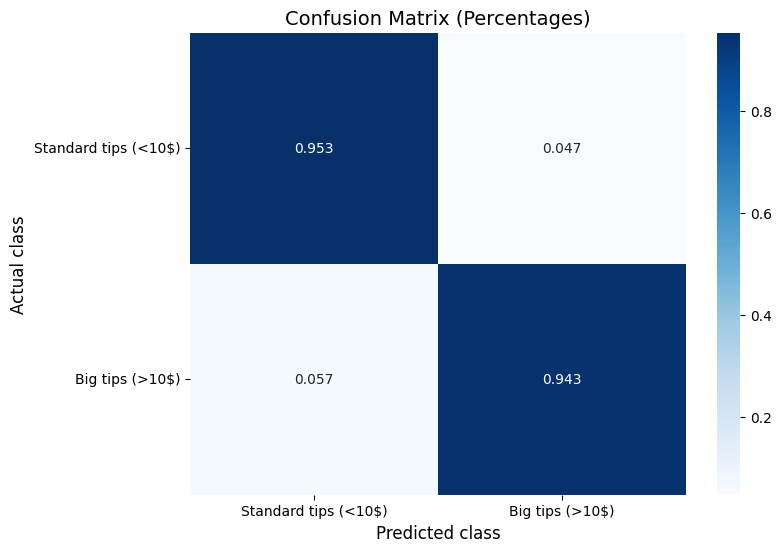

In [46]:
# Generar la matriz de confusión
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Convertir la matriz de confusión a porcentaje
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Crear el heatmap con porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".3f", cmap="Blues", cbar=True)

# Cambiar las etiquetas
plt.xlabel('Predicted class', fontsize=12)
plt.ylabel('Actual class', fontsize=12)
plt.xticks([0.5, 1.5], ['Standard tips (<10$)', 'Big tips (>10$)'], fontsize=10)
plt.yticks([0.5, 1.5], ['Standard tips (<10$)', 'Big tips (>10$)'], fontsize=10, rotation=0)

# Título opcional
plt.title('Confusion Matrix (Percentages)', fontsize=14)
plt.show()

                 Feature  Importance
15         high_distance    0.499552
12             high_fare    0.441647
7       tolls_percentage    0.018787
8      PULocationEncoded    0.011091
0          trip_duration    0.009567
1        avg_speed(km/h)    0.008759
9      DOLocationEncoded    0.005813
3   congestion_surcharge    0.002287
4            Airport_fee    0.001746
11           medium_fare    0.000329
6            pickup_Time    0.000144
2        passenger_count    0.000138
5             pickup_DoW    0.000097
14       medium_distance    0.000045
10              low_fare    0.000000
13          low_distance    0.000000


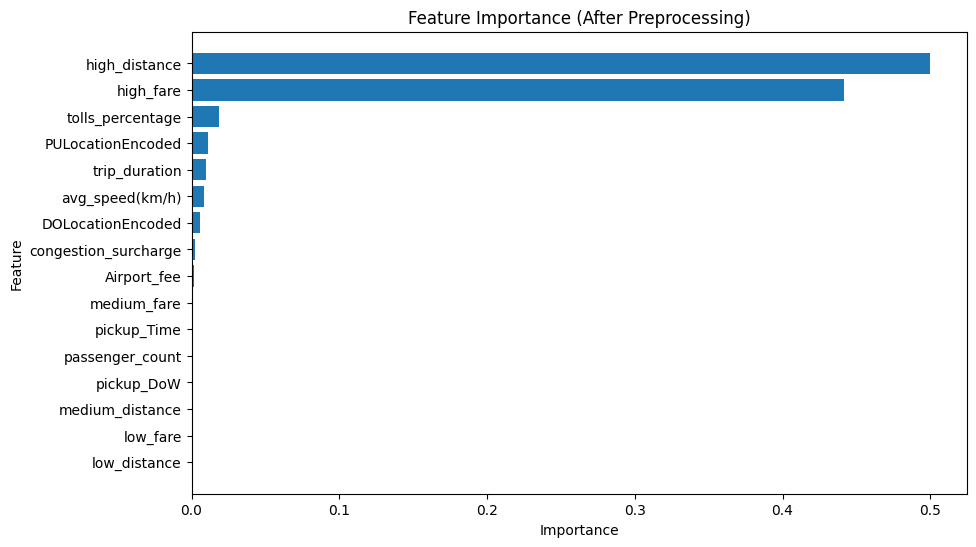

In [47]:
# Extraer el preprocesador y el clasificador
preprocessor = clf.best_estimator_.named_steps['preprocessor']
classifier = clf.best_estimator_.named_steps['classifier']

# Obtener nombres de columnas transformadas y no transformadas
log_columns = ['trip_duration', 'avg_speed(km/h)']
non_transformed_columns = [col for col in X_train.columns if col not in log_columns]

# Combinar nombres en el mismo orden que el ColumnTransformer
feature_names_transformed = log_columns + non_transformed_columns

# Extraer las importancias del clasificador
if hasattr(classifier, 'feature_importances_'):
    feature_importances = classifier.feature_importances_
else:
    raise AttributeError("El clasificador no tiene el atributo 'feature_importances_'")

# Asociar las importancias con las características
importance_df = pd.DataFrame({
    'Feature': feature_names_transformed,
    'Importance': feature_importances
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las importancias
print(importance_df)

# Visualización opcional

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (After Preprocessing)')
plt.show()

Este modelo mejora el recall respecto al anterior

In [48]:
# Guardamos el modelo en un archivo con pickle
with open('classifier_4.pkl', 'wb') as file:
    pickle.dump(clf.best_estimator_, file)

print("Modelo guardado como 'classifier_4.pkl'")

Modelo guardado como 'classifier_4.pkl'


Esta visualización de los histogramas tras su transformación, sugiere que para las variables trip_duration y avg_speed, la transformación logarítmica fue muy exitosa ya que las transformadas presentan distribuciones normales.  
Para trip_distance y fare_amount, la distribución sugiere que esas variables podrían estar compuestas por subgrupos o clústers. Por tanto, para el siguiente clasificador se probará a clasificar esas dos variables.